JM: 21 Mar 2024 (TDA sample analysis, taken and modified from giotto-tda)

In [1]:
# semi-generic loading and formatting options

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import cmocean
import sys
scivis_path = "/home/jclmak/Documents/python/scivis_cm/KeyColormaps/"
sys.path.append(scivis_path)
import cm_xml_to_matplotlib as scivis_cm
wave4_cm = scivis_cm.make_cmap(scivis_path + "3Wbgy5.xml")
# scivis_cm.plot_cmap(wave4_cm)

# define some defaults
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r" # \"*_r\" is reverse of standard colour\n",
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 10.0

--------------------------

### 1) Synthetic data generation

Randomly generate some full signals (pure + noise) and pure signals. `labels` has a `True` entry if there is in fact a signal there.

In [2]:
from generate_datasets import make_gravitational_waves
from pathlib import Path

R = 0.65  # orig = 0.65, (0.075, 0.65), small values = lots of noise (low SNR)
n_signals = 100
DATA = Path("./")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, 
    r_min=R, r_max=R, 
#     n_snr_values=1, 
    downsample_factor=2  # factors of 4, default is 2
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

# pick out the index of the first dud signal and one with an actual signal (i.e. just noise and noise + gw wave)
dud_idx, hit_idx = np.argmin(labels), np.argmax(labels)  # label = 0 is a dud

gw_ctrl = gw_signals[hit_idx]  # just pick one out

Number of noisy signals: 100
Number of timesteps per series: 8692


--------------------------

### 2) Good practice number 1 of data analysis: plot out the damn data first...

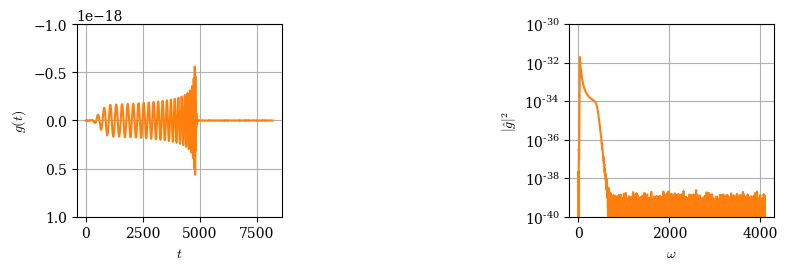

In [6]:
# FFT analysis (full, no windowing)

fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))

ax[0].plot(gw_ctrl, "C1")
ax[0].set_ylim([1e-18, -1e-18])
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$g(t)$")
ax[0].grid()

ax[1].remove()

ax[2].semilogy(np.abs(np.fft.rfft(gw_ctrl))**2, "C1")
ax[2].set_xlabel(r"$\omega$")
ax[2].set_ylabel(r"$|\hat{g}|^2$")
ax[2].set_ylim([1e-40, 1e-30])
ax[2].grid()

fig.savefig("pure_gw.pdf", dpi=100, bbox_inches="tight")

In [8]:
# generate some noise

def rand_fig(R, gw_ctrl, ylim=None, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    hit = np.random.randint(3)
    print(f"hit = {hit+1}")

    noise = (1e-19 / R) * np.random.randn(len(gw_ctrl), 3)
    
    if ylim is None:
        ylim = 1e-18

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 4))

    ax[0][0].remove()
    ax[0][2].remove()

    ax[0][1].plot(gw_ctrl, "C1")
    ax[0][1].set_title("pure signal")
    ax[0][1].set_ylim([-ylim, ylim])
    ax[0][1].grid()
    ax[0][1].set_xticklabels([])

    for j in range(3):
        if j == hit:
            ax[1][j].plot(noise[:, j] + gw_ctrl)
        else:
            ax[1][j].plot(noise[:, j])
        ax[1][j].set_ylim([-ylim, ylim])
        ax[1][j].grid()
        
        if j > 0:
            ax[1][j].set_yticklabels([])
            
    return fig, ax

def rand_fig_fft(R, gw_ctrl, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    hit = np.random.randint(3)
    print(f"hit = {hit+1}")

    noise = (1e-19 / R) * np.random.randn(len(gw_ctrl), 3)
    ylim = 1e-18

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 4))

    ax[0][0].remove()
    ax[0][2].remove()

    ax[0][1].semilogy(np.abs(np.fft.rfft(gw_ctrl))**2, "C1")
    ax[0][1].set_title("pure signal")
    ax[0][1].set_ylim([1e-40, 1e-30])
    ax[0][1].grid()
    ax[0][1].set_xticklabels([])

    for j in range(3):
        if j == hit:
            ax[1][j].semilogy(np.abs(np.fft.rfft(noise[:, j] + gw_ctrl))**2)
        else:
            ax[1][j].semilogy(np.abs(np.fft.rfft(noise[:, j]))**2)
        ax[1][j].set_ylim([1e-40, 1e-30])
        ax[1][j].grid()
        
        if j > 0:
            ax[1][j].set_yticklabels([])
            
    return fig, ax
        
def rand_fig_high_pass(R, gw_ctrl, wavenumber, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    hit = np.random.randint(3)
    print(f"hit = {hit+1}")

    noise = (1e-19 / R) * np.random.randn(len(gw_ctrl), 3)
    ylim = 1e-18

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 4))

    ax[0][0].remove()
    ax[0][2].remove()
    
    gw_h_high_pass = np.fft.rfft(gw_ctrl)
    gw_h_high_pass[wavenumber::] = 0.0
    gw_high_pass = np.fft.irfft(gw_h_high_pass)

    ax[0][1].plot(gw_high_pass, "C1")
    ax[0][1].set_title("filtered signal")
    ax[0][1].set_ylim([-ylim, ylim])
    ax[0][1].grid()
    ax[0][1].set_xticklabels([])

    for j in range(3):
        if j == hit:
            sig_h_high_pass = np.fft.rfft(noise[:, j] + gw_ctrl)
            sig_h_high_pass[wavenumber::] = 0.0
            sig_high_pass = np.fft.irfft(sig_h_high_pass)
        else:
            sig_h_high_pass = np.fft.rfft(noise[:, j])
            sig_h_high_pass[wavenumber::] = 0.0
            sig_high_pass = np.fft.irfft(sig_h_high_pass)
        
        ax[1][j].plot(sig_high_pass)
        ax[1][j].set_ylim([-ylim, ylim])
        ax[1][j].grid()
        
        if j > 0:
            ax[1][j].set_yticklabels([])
            
    return fig, ax

hit = 3


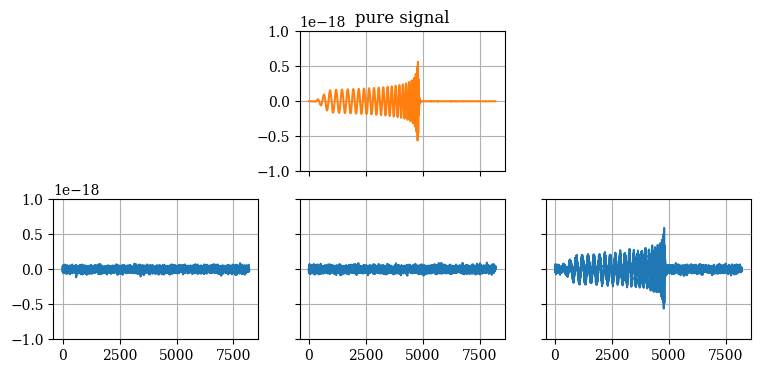

In [9]:
# low noise regime

fig, ax = rand_fig(4, gw_ctrl)

fig.savefig("signal_low_noise.pdf", dpi=100, bbox_inches="tight")

hit = 3


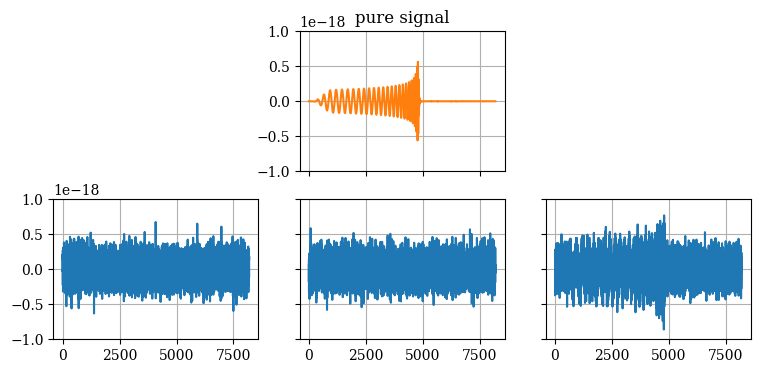

In [51]:
# more noise

fig, ax = rand_fig(0.65, gw_ctrl, seed=4167)

fig.savefig("signal_mid_noise.pdf", dpi=100, bbox_inches="tight")

hit = 3


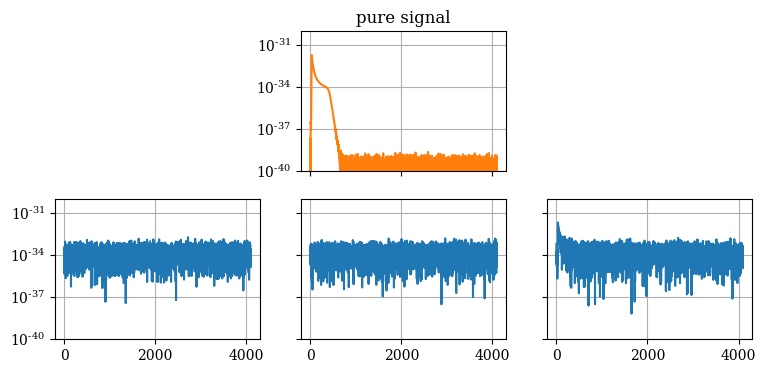

In [53]:
# more noise but in FFT form

fig, ax = rand_fig_fft(0.65, gw_ctrl, seed=4167)

fig.savefig("signal_mid_noise_psd.pdf", dpi=100, bbox_inches="tight")

hit = 3


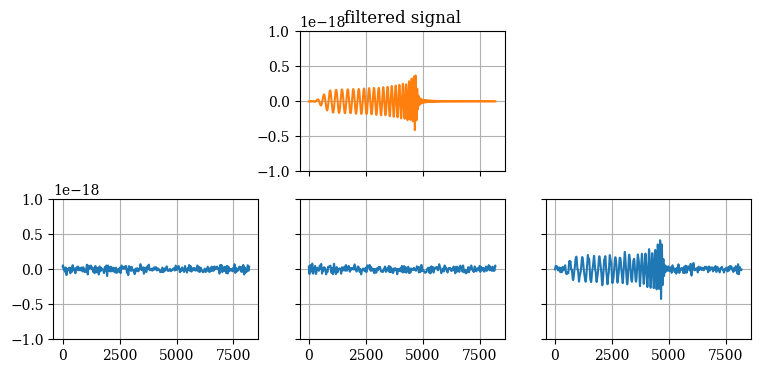

In [54]:
# more noise but high-passed

fig, ax = rand_fig_high_pass(0.65, gw_ctrl, wavenumber=150, seed=4167)

fig.savefig("signal_mid_noise_high_pass.pdf", dpi=100, bbox_inches="tight")

hit = 3


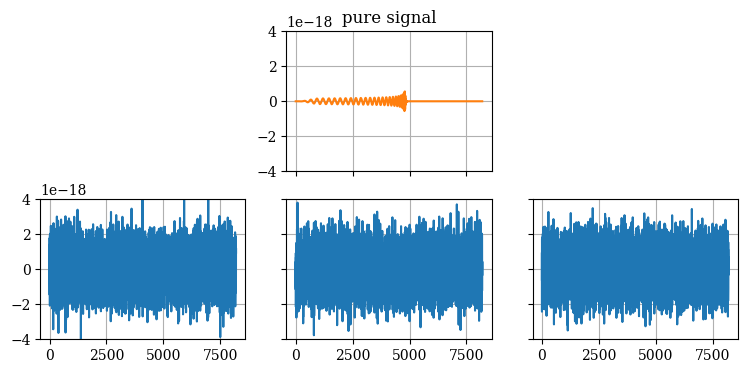

In [55]:
# even more noise!

fig, ax = rand_fig(0.1, gw_ctrl, ylim=4e-18, seed=4167)

fig.savefig("signal_high_noise.pdf", dpi=100, bbox_inches="tight")

hit = 3


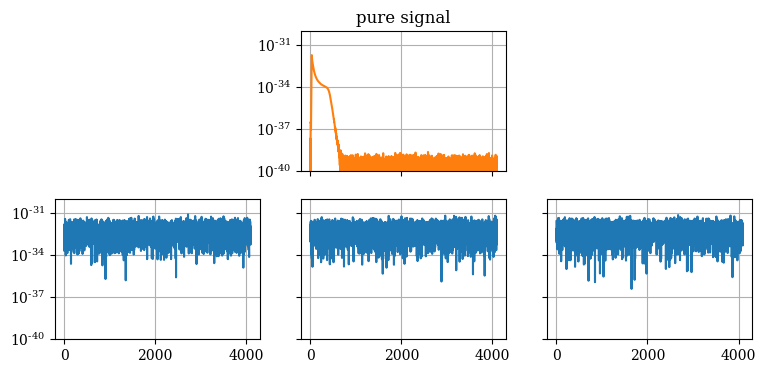

In [56]:
fig, ax = rand_fig_fft(0.1, gw_ctrl, seed=4167)

fig.savefig("signal_high_noise_psd.pdf", dpi=100, bbox_inches="tight")

hit = 3


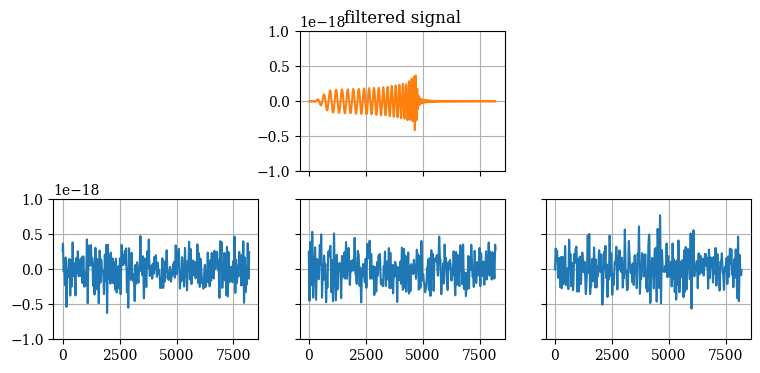

In [57]:
fig, ax = rand_fig_high_pass(0.1, gw_ctrl, wavenumber=150, seed=4167)

fig.savefig("signal_high_noise_high_pass.pdf", dpi=100, bbox_inches="tight")

--------------------------

### 3) Takens embedding

Phase space portrait in terms of delayed variables (should preserve topology)

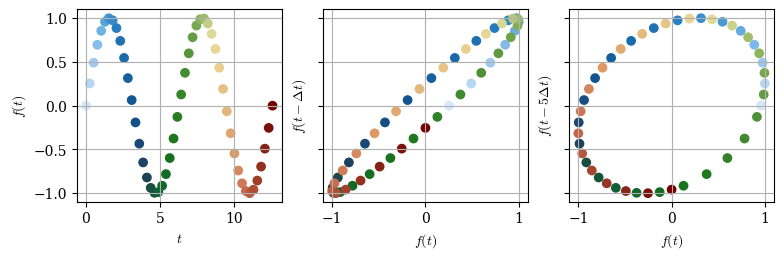

In [16]:
# essentially trivial example of 2d Takens embedding

t = np.linspace(0, 4*np.pi, 50)
f = np.sin(t)

fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))

ax[0].scatter(t, f, c=t, cmap=wave4_cm)
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f(t)$")
ax[0].grid()

stride = 1
g = np.zeros((len(f)-stride, 2))
g[:, 0] = f[stride::]
g[:, 1] = f[0:-stride]

ax[1].scatter(g[:, 0], g[:, 1], c=t[0:-stride], cmap=wave4_cm)
ax[1].set_xlabel(r"$f(t)$")
ax[1].set_ylabel(r"$f(t-\Delta t)$")
ax[1].set_yticklabels([])
ax[1].grid()

stride = 5
g = np.zeros((len(f)-stride, 2))
g[:, 0] = f[stride::]
g[:, 1] = f[0:-stride:]

ax[2].scatter(g[:, 0], g[:, 1], c=t[0:-stride], cmap=wave4_cm)
ax[2].set_xlabel(r"$f(t)$")
ax[2].set_ylabel(r"$f(t-%i\Delta t)$" % stride)
ax[2].set_yticklabels([])
ax[2].grid()

fig.savefig("takens_circle_2d.pdf", dpi=100, bbox_inches="tight")

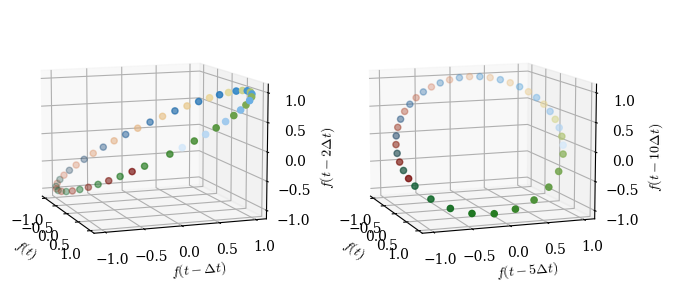

In [17]:
# 3d Takens embedding?

t = np.linspace(0, 4*np.pi, 50)
f = np.sin(t)

fig = plt.figure(figsize=(12, 4))

###

stride = 1
g = np.zeros((len(f)-(2*stride), 3))
g[:, 0] = f[2*stride::]
g[:, 1] = f[stride:-stride]
g[:, 2] = f[0:-(stride+1)]

ax = fig.add_subplot(1, 3, 2, projection="3d")

ax.scatter(g[:, 0], g[:, 1], g[:, 2], c=t[0:-2*stride], cmap=wave4_cm)
ax.set_xlabel(r"$f(t)$")
ax.set_ylabel(r"$f(t-\Delta t)$")
ax.set_zlabel(r"$f(t-2\Delta t)$")
ax.view_init(elev=10, azim=-20)
ax.grid()

###

stride = 5
g = np.zeros((len(f)-(2*stride), 3))
g[:, 0] = f[2*stride::]
g[:, 1] = f[stride:-stride:]
g[:, 2] = f[0:-2*stride:]

ax = fig.add_subplot(1, 3, 3, projection="3d")

ax.scatter(g[:, 0], g[:, 1], g[:, 2], c=t[0:-2*stride], cmap=wave4_cm)
ax.set_xlabel(r"$f(t)$")
ax.set_ylabel(r"$f(t-%i\Delta t)$" % (stride))
ax.set_zlabel(r"$f(t-%i\Delta t)$" % (2*stride))
ax.view_init(elev=10, azim=-20)
ax.grid()

fig.savefig("takens_circle_3d.pdf", dpi=100, bbox_inches="tight")

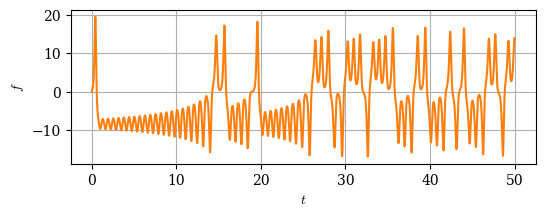

In [18]:
# slightly more complicated example: Lorenz 63 case

def Lorenz63_rhs(w, sigma, beta, rho):
    """
    w = [x, y, z] is the state array
    """
    wdot = np.zeros(3)
    wdot[0] = sigma * (w[1] - w[0])
    wdot[1] = w[0] * (rho - w[2]) - w[1]
    wdot[2] = w[0] * w[1] - beta * w[2]
    
    return wdot

def RK4(dt, Lorenz63_rhs, w, sigma, beta, rho):
    """
    passes wdot through to do the RK4 time-stepping
    """
    k1 = Lorenz63_rhs(w,               sigma, beta, rho) # RK4 increments
    k2 = Lorenz63_rhs(w + k1 * dt/2.0, sigma, beta, rho)
    k3 = Lorenz63_rhs(w + k2 * dt/2.0, sigma, beta, rho)
    k4 = Lorenz63_rhs(w + k3 * dt    , sigma, beta, rho)
    w_new = w + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    
    return w_new

# parameters
sigma, beta, rho = 10.0, 8.0/3.0, 28.0
dt = 0.01
t0, tf = 0, 50
t_vec = np.arange(t0, tf+dt, dt) # add one extra to include end point

w0 = np.array([0.0, 1.0, 1.05])
f = np.zeros((len(t_vec), 3))

# initial condition
f[0, :] = w0

for i in range(1, len(t_vec)):
    f[i, :] = RK4(dt, Lorenz63_rhs, f[i-1, :], sigma, beta, rho)

fig, ax = plt.subplots(figsize = (6, 2))
ax.plot(t_vec, f[:, 0], "C1")
ax.grid()
ax.set_ylabel(r"$f$")
ax.set_xlabel(r"$t$")

fig.savefig("takens_lorenz_x.pdf", dpi=100, bbox_inches="tight")

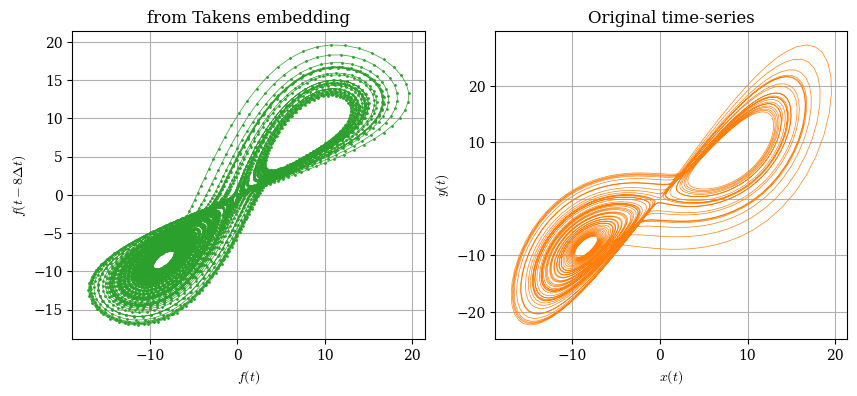

In [19]:
# 2d Takens embedding here

fig = plt.figure(figsize = (10, 4))

stride = 8
g = np.zeros((len(f)-(2*stride), 2))
g[:, 0] = f[2*stride::, 0]
g[:, 1] = f[stride:-stride:, 0]

ax = fig.add_subplot(1, 2, 1)
ax.plot(g[:, 0], g[:, 1], "C2o-", lw=0.5, markersize=1)
ax.set_xlabel(r"$f(t)$")
ax.set_ylabel(r"$f(t-%i\Delta t)$" % (stride))
ax.grid()
ax.set_title("from Takens embedding")

ax = fig.add_subplot(1, 2, 2)
ax.plot(f[:, 0], f[:, 1], "C1", lw=0.5)
ax.set_xlabel(r"$x(t)$")
ax.set_ylabel(r"$y(t)$")
ax.grid()
ax.set_title("Original time-series")

fig.savefig("takens_lorenz_2d.pdf", dpi=100, bbox_inches="tight")

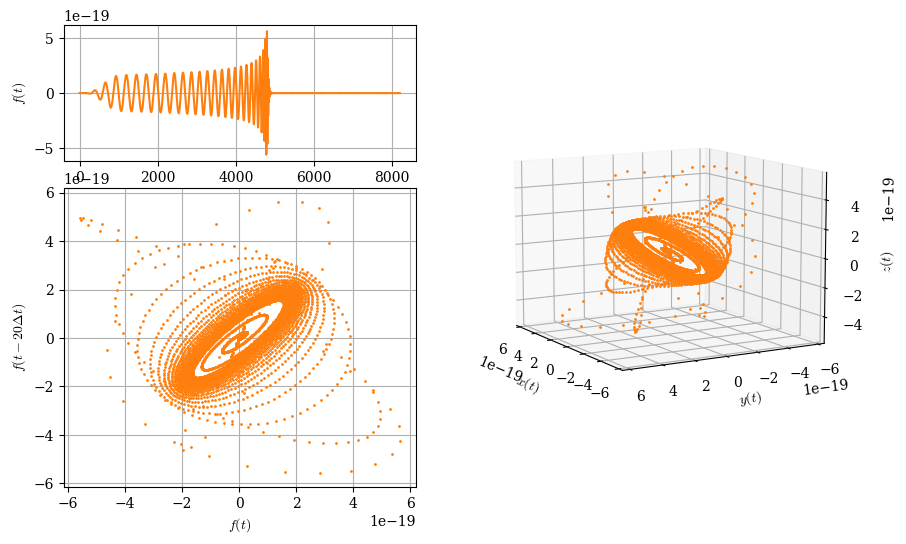

In [20]:
# example for the pure signal

fig = plt.figure(figsize = (10, 6))

f = gw_ctrl

stride = 20
g = np.zeros((len(f)-(2*stride), 3))
g[:, 0] = f[2*stride::]
g[:, 1] = f[stride:-stride:]
g[:, 2] = f[0:-2*stride:]

ax = plt.subplot2grid((3, 2), (0, 0))
ax.plot(f, "C1")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f(t)$")
ax.grid()

ax = plt.subplot2grid((3, 2), (1, 0), rowspan=2)
ax.plot(g[:, 0], g[:, 1], "C1o", markersize=1)
ax.set_xlabel(r"$f(t)$")
ax.set_ylabel(r"$f(t-%i\Delta t)$" % (stride))
ax.grid()

ax = plt.subplot2grid((2, 2), (0, 1), rowspan=2, projection="3d")
ax.plot(g[:, 0], g[:, 1], g[:, 2], "C1o", markersize=1)
ax.set_xlabel(r"$x(t)$")
ax.set_ylabel(r"$y(t)$")
ax.set_zlabel(r"$z(t)$")
ax.view_init(elev=10, azim=150)

fig.savefig("takens_gw.pdf", dpi=100, bbox_inches="tight")

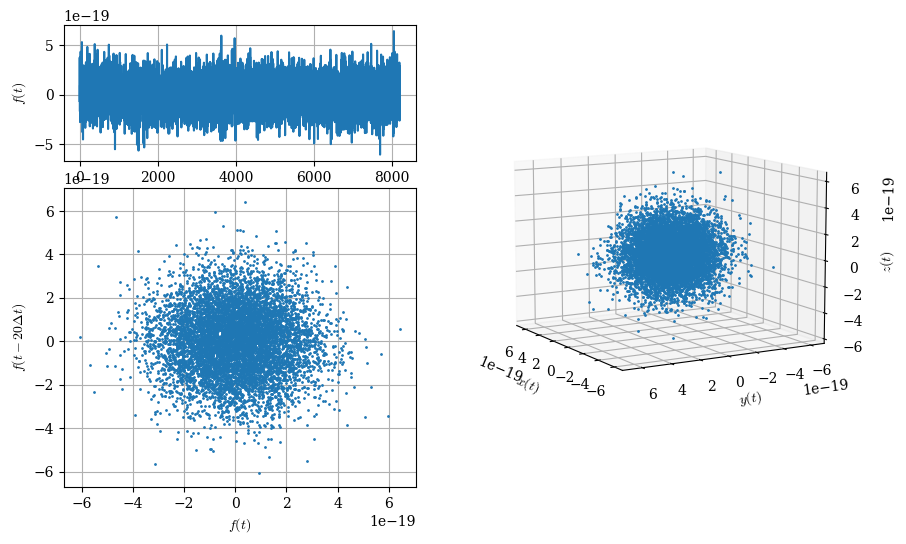

In [23]:
# similar thing but for a pure noise case

fig = plt.figure(figsize = (10, 6))

R = 0.65

noise = (1e-19 / R) * np.random.randn(len(gw_ctrl))

f = noise

stride = 20
g = np.zeros((len(f)-(2*stride), 3))
g[:, 0] = f[2*stride::]
g[:, 1] = f[stride:-stride:]
g[:, 2] = f[0:-2*stride:]

ax = plt.subplot2grid((3, 2), (0, 0))
ax.plot(f, "C0")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f(t)$")
ax.grid()

ax = plt.subplot2grid((3, 2), (1, 0), rowspan=2)
ax.plot(g[:, 0], g[:, 1], "C0o", markersize=1)
ax.set_xlabel(r"$f(t)$")
ax.set_ylabel(r"$f(t-%i\Delta t)$" % (stride))
ax.grid()

ax = plt.subplot2grid((2, 2), (0, 1), rowspan=2, projection="3d")
ax.plot(g[:, 0], g[:, 1], g[:, 2], "C0o", markersize=1)
ax.set_xlabel(r"$x(t)$")
ax.set_ylabel(r"$y(t)$")
ax.set_zlabel(r"$z(t)$")
ax.view_init(elev=10, azim=150)

fig.savefig("takens_noise.pdf", dpi=100, bbox_inches="tight")

--------------------------

### 3.5) Takens embedding using the `giotto-tda` pipeline

Do a high dim embedding, PCA it down

In [29]:
# using gtda syntax and sklearn-PCA: initialise a embedding and PCA instance

from gtda.time_series import SingleTakensEmbedding
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

embedding_dimension = 30
embedding_time_delay = 5
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", 
    time_delay=embedding_time_delay, 
    dimension=embedding_dimension, 
    stride=stride,
#     n_jobs=6,  # number of processors
)

pca = PCA(n_components=3)  # PCA down to 3d

In [19]:
# do the embedding and PCA projection

# for pure signal
gw_takens = embedder.fit_transform(gw_ctrl)
gw_takens_pca = pca.fit_transform(gw_takens)

# for pure noise
noise_takens = embedder.fit_transform(noise)
noise_takens_pca = pca.fit_transform(noise_takens)

Text(0.5, 0.92, 'just noise')

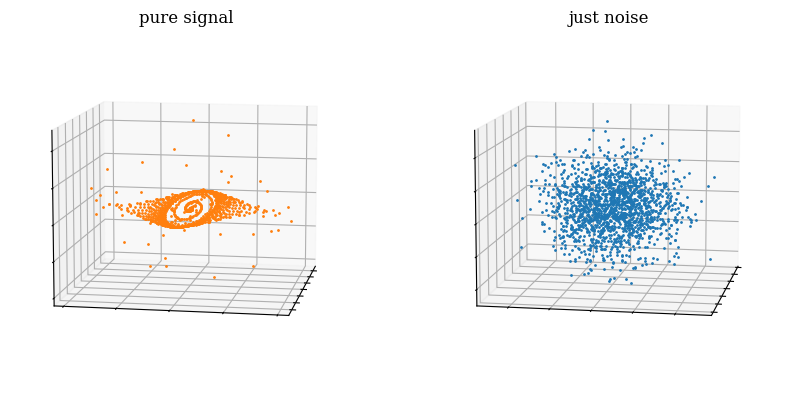

In [20]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot(gw_takens_pca[:, 0], gw_takens_pca[:, 1], gw_takens_pca[:, 2], "C1o", markersize=1)
ax.view_init(elev=10, azim=10)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title("pure signal")

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.plot(noise_takens_pca[:, 0], noise_takens_pca[:, 1], noise_takens_pca[:, 2], "C0o", markersize=1)
ax.view_init(elev=10, azim=10)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title("just noise")

In [21]:
plot_point_cloud(gw_takens_pca)

In [22]:
plot_point_cloud(noise_takens_pca)

--------------------------

### 4) Vietoris-Rips persistent homology

Compute the VR persistent homology.

In [26]:
from gtda.homology import VietorisRipsPersistence

homology_dimensions = [0, 1, 2]  # compute up to 2-homologies

In [30]:
# example on the periodic signal first

t = np.linspace(0, 4*np.pi, 50)
f = np.sin(t)

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=5,
    dimension=3,
    stride=1,  # no down-sampling here
)

f_takens = embedder_periodic.fit_transform(f)

# promote this to (n_samples, n_points, n_dimensions) for use in VR persistence [n_samples = 1 so trivial here]
f_takens = f_takens[None, :, :]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=2
)
persistence_diagram = persistence.fit_transform(f_takens)

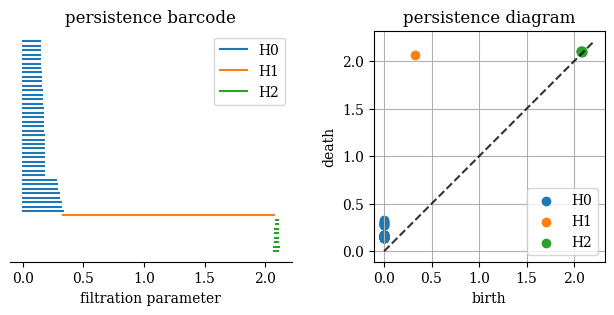

In [31]:
# some plots of summary statistics of the homology classes

lim = persistence_diagram[0, :, 1].max()+0.1

H0_class = np.where(persistence_diagram[0, :, 2] == 0)[0]
H1_class = np.where(persistence_diagram[0, :, 2] == 1)[0]
H2_class = np.where(persistence_diagram[0, :, 2] == 2)[0]

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

# persistence barcode

count = persistence_diagram.shape[1]
lines = []
for i in H0_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C0")
    count -= 1
for i in H1_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C1")
    count -= 1
for i in H2_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C2")
    count -= 1
ax[0].set_xlabel("filtration parameter")
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_yticks([])
ax[0].set_title("persistence barcode")
ax[0].legend((lines[H0_class[0]], lines[H1_class[0]], lines[H2_class[0]]), ("H0", "H1", "H2"))

# persistence diagram itself

ax[1].scatter(persistence_diagram[0, H0_class, 0], persistence_diagram[0, H0_class, 1], cmap="C0", label="H0")
ax[1].scatter(persistence_diagram[0, H1_class, 0], persistence_diagram[0, H1_class, 1], cmap="C1", label="H1")
ax[1].scatter(persistence_diagram[0, H2_class, 0], persistence_diagram[0, H2_class, 1], cmap="C2", label="H2")
ax[1].plot(np.linspace(0, lim), np.linspace(0, lim), 'k--', alpha=0.8)
ax[1].legend(loc=4)
ax[1].set_aspect("equal")
ax[1].set_xlabel("birth")
ax[1].set_ylabel("death")
ax[1].grid()
ax[1].set_title("persistence diagram")

fig.savefig("persistence_circle.pdf", dpi=100, bbox_inches="tight")

--------------------
### 4.5) similar pipeline but for synthetic example

Computing $H_2$ can get quite expensive and slow. If `stride = 10` then $H_2$ is reasonably fast, while `stride = 5` takes around half a minute for a original array of length 4096 (`stride = 5` means a further down-sampling by a roughly a factor of 5 from the 4096).

In [32]:
# analogous pipeline but on the gw signals etc.

R = 0.65  # weak noise
noise = (1e-19 / R) * np.random.randn(len(gw_ctrl))

embedding_dimension = 200
embedding_time_delay = 30
stride = 10
homology_dimensions = [0, 1]

embedder = SingleTakensEmbedding(
    parameters_type="search", 
    time_delay=embedding_time_delay, 
    dimension=embedding_dimension, 
    stride=stride,
    n_jobs=4,  # number of processors
)

pca = PCA(n_components=3)  # PCA down to 3d

# for pure signal
gw_takens = embedder.fit_transform(gw_ctrl)
# gw_takens_pca = gw_takens
gw_takens_pca = pca.fit_transform(gw_takens)

# for pure noise
noise_takens = embedder.fit_transform(noise)
# noise_takens_pca = noise_takens
noise_takens_pca = pca.fit_transform(noise_takens)

# combined signal
f_takens = embedder.fit_transform(gw_ctrl + noise)
# f_takens_pca = f_takens
f_takens_pca = pca.fit_transform(f_takens)

In [33]:
# compute the persistence (takes quite a bit of time if class 2 homologies are asked for)

# promote this to (n_samples, n_points, n_dimensions) for use in VR persistence
gw_takens_pca = gw_takens_pca[None, :, :]
noise_takens_pca = noise_takens_pca[None, :, :]
f_takens_pca = f_takens_pca[None, :, :]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=4
)
persistence_pure_gw = persistence.fit_transform(gw_takens_pca)
persistence_pure_noise = persistence.fit_transform(noise_takens_pca)
persistence_f = persistence.fit_transform(f_takens_pca)

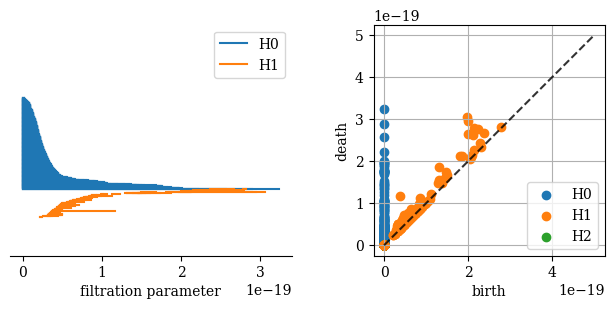

In [58]:
# some plots of summary statistics of the homology classes (pure signal)

persistence_diagram = persistence_pure_gw

# lim = persistence_diagram[0, :, 1].max() * 1.1
lim = 5e-19

H0_class = np.where(persistence_diagram[0, :, 2] == 0)[0]
H1_class = np.where(persistence_diagram[0, :, 2] == 1)[0]
H2_class = np.where(persistence_diagram[0, :, 2] == 2)[0]

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

# persistence barcode

count = persistence_diagram.shape[1]
lines = []
for i in H0_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C0")
    count -= 1
for i in H1_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C1")
    count -= 1
for i in H2_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C2")
    count -= 1
ax[0].set_xlabel("filtration parameter")
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_yticks([])
ax[0].legend((lines[H0_class[0]], lines[H1_class[0]]), ("H0", "H1"))

# persistence diagram itself

ax[1].scatter(persistence_diagram[0, H0_class, 0], persistence_diagram[0, H0_class, 1], cmap="C0", label="H0")
ax[1].scatter(persistence_diagram[0, H1_class, 0], persistence_diagram[0, H1_class, 1], cmap="C1", label="H1")
ax[1].scatter(persistence_diagram[0, H2_class, 0], persistence_diagram[0, H2_class, 1], cmap="C2", label="H2")
ax[1].plot(np.linspace(0, lim), np.linspace(0, lim), 'k--', alpha=0.8)
ax[1].legend(loc=4)
ax[1].set_aspect("equal")
ax[1].set_xlabel("birth")
ax[1].set_ylabel("death")
ax[1].grid()

fig.savefig("persistence_pure_gw.pdf", dpi=100, bbox_inches="tight")

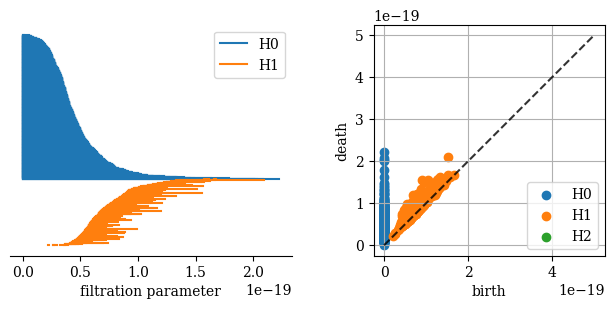

In [59]:
# some plots of summary statistics of the homology classes (noise)

persistence_diagram = persistence_pure_noise

# lim = persistence_diagram[0, :, 1].max() * 1.1
lim = 5e-19

H0_class = np.where(persistence_diagram[0, :, 2] == 0)[0]
H1_class = np.where(persistence_diagram[0, :, 2] == 1)[0]
H2_class = np.where(persistence_diagram[0, :, 2] == 2)[0]

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

# persistence barcode

count = persistence_diagram.shape[1]
lines = []
for i in H0_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C0")
    count -= 1
for i in H1_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C1")
    count -= 1
for i in H2_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C2")
    count -= 1
ax[0].set_xlabel("filtration parameter")
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_yticks([])
ax[0].legend((lines[H0_class[0]], lines[H1_class[0]]), ("H0", "H1"))

# persistence diagram itself

ax[1].scatter(persistence_diagram[0, H0_class, 0], persistence_diagram[0, H0_class, 1], cmap="C0", label="H0")
ax[1].scatter(persistence_diagram[0, H1_class, 0], persistence_diagram[0, H1_class, 1], cmap="C1", label="H1")
ax[1].scatter(persistence_diagram[0, H2_class, 0], persistence_diagram[0, H2_class, 1], cmap="C2", label="H2")
ax[1].plot(np.linspace(0, lim), np.linspace(0, lim), 'k--', alpha=0.8)
ax[1].legend(loc=4)
ax[1].set_aspect("equal")
ax[1].set_xlabel("birth")
ax[1].set_ylabel("death")
ax[1].grid()

fig.savefig("persistence_pure_noise.pdf", dpi=100, bbox_inches="tight")

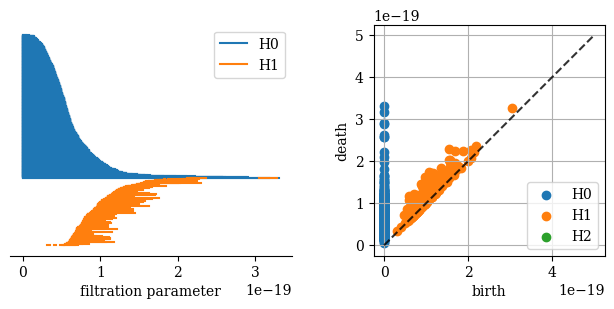

In [60]:
# some plots of summary statistics of the homology classes (combined signal)

persistence_diagram = persistence_f

# lim = persistence_diagram[0, :, 1].max() * 1.1
lim = 5e-19

H0_class = np.where(persistence_diagram[0, :, 2] == 0)[0]
H1_class = np.where(persistence_diagram[0, :, 2] == 1)[0]
H2_class = np.where(persistence_diagram[0, :, 2] == 2)[0]

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

# persistence barcode

count = persistence_diagram.shape[1]
lines = []
for i in H0_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C0")
    count -= 1
for i in H1_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C1")
    count -= 1
for i in H2_class:
    lines += ax[0].plot([persistence_diagram[0, i, 0], persistence_diagram[0, i, 1]], [count, count], "C2")
    count -= 1
ax[0].set_xlabel("filtration parameter")
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_yticks([])
ax[0].legend((lines[H0_class[0]], lines[H1_class[0]]), ("H0", "H1"))

# persistence diagram itself

ax[1].scatter(persistence_diagram[0, H0_class, 0], persistence_diagram[0, H0_class, 1], cmap="C0", label="H0")
ax[1].scatter(persistence_diagram[0, H1_class, 0], persistence_diagram[0, H1_class, 1], cmap="C1", label="H1")
ax[1].scatter(persistence_diagram[0, H2_class, 0], persistence_diagram[0, H2_class, 1], cmap="C2", label="H2")
ax[1].plot(np.linspace(0, lim), np.linspace(0, lim), 'k--', alpha=0.8)
ax[1].legend(loc=4)
ax[1].set_aspect("equal")
ax[1].set_xlabel("birth")
ax[1].set_ylabel("death")
ax[1].grid()

fig.savefig("persistence_noisy_signal.pdf", dpi=100, bbox_inches="tight")

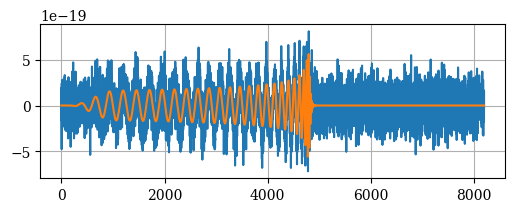

In [40]:
fig = plt.figure(figsize=(6, 2))
ax = plt.axes()
ax.plot(noise + gw_ctrl, "C0")
ax.plot(gw_ctrl, "C1")
ax.grid()

-------------
### 5) Machine Learning pipeline

Minor differences maybe, difficult to pick out by eye, by can do

1. statistical testing (e.g. null hypothesis = persistent diagram features is "that" of noise, for some metric)
2. train up a classifier (e.g., random forest, neural network)

Brester & Jung (2019; arXiv) uses CNN. Going to use a logistic regression here.

In [41]:
# load the relevant objects

from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding  # this is used for a batch (cf. SingleTakensEmbedding above)

In [42]:
# generate the batch of signals

R = 0.65  # orig = 0.65, (0.075, 0.65), small values = lots of noise (low SNR)
n_signals = 1000
DATA = Path("./")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, 
    r_min=R, r_max=R, 
#     r_min=0.075, r_max=0.65,
#     n_snr_values=1, 
    downsample_factor=2  # factors of 4, default is 2
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 1000
Number of timesteps per series: 8692


In [43]:
# Takens embedding and projection onto dimension 3 by PCA

embedding_dimension = 200
embedding_time_delay = 10
stride = 10
embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)
batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=4)

In [44]:
# calculate persistence and 

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
scaling = Scaler()
entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

In [45]:
# create pipeline
steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]
topological_transformer = Pipeline(steps)
topological_transformer

Pipeline(steps=[('embedder',
                 TakensEmbedding(dimension=200, stride=10, time_delay=10)),
                ('pca',
                 CollectionTransformer(n_jobs=4,
                                       transformer=PCA(n_components=3))),
                ('persistence',
                 VietorisRipsPersistence(homology_dimensions=[0, 1],
                                         n_jobs=-1)),
                ('scaling', Scaler()),
                ('entropy',
                 PersistenceEntropy(nan_fill_value=-10, normalize=True))])

In [46]:
# generate features and then train a model

features = topological_transformer.fit_transform(noisy_signals)

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/metaestimators.py:201: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }

    for k, v in res.items():
        print(k, round(v, 3))

In [48]:
# split dataset and train with logistic regression

X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.1, random_state=4167
)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

* ROC = Receiver operating characteristic, true positive rate against the false positive rate at each threshold setting
* AUC = Area under the ROC Curve, score for calculating, measure of skill for binary classifier (0.5 is crap, 0.9 onwards is pretty good, 1 is perfect)

In [49]:
print_scores(model)

Accuracy on train: 0.719
ROC AUC on train: 0.776
Accuracy on valid: 0.69
ROC AUC on valid: 0.769


In [50]:
#  1 = 1 - 0, so if model predicts signal when there isn't one (false positive)
#  0 = 1 - 1 or 0 - 0, when it did it right
# -1 = 0 -1, so if model fails to predict a signal when it is there (false negative)

dummy = model.predict(features) - labels
print(f" correct predictions {np.sum(dummy ==  0)} / {len(dummy)}")
print(f"   false positives   {np.sum(dummy ==  1)} / {len(dummy)}")
print(f"   false negatives   {np.sum(dummy == -1)} / {len(dummy)}")

 correct predictions 716 / 1000
   false positives   84 / 1000
   false negatives   200 / 1000


In [62]:
features.shape

(1000, 2)

In [70]:
labels.shape

(1000,)

In [71]:
np.asarray(noisy_signals).shape

(1000, 8692)